<a href="https://colab.research.google.com/github/GolovatyDmitry/Projects/blob/main/user_behavior_in_the_app/sales_funel_and_aab_test_for_app_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of contents<span class="tocSkip"></span></h1>


1.   Reading and data preparation

2.   Data exploration and validation

3. Funnel analysis

4. A/A/B test results analysis

5. Conclusions



# Analysis of a grocery shopping app

The research objective is to understand the behavior of users of a mobile app that sells food products.

The sales funnel needs to be examined to understand how users reach the point of purchase.

It is also necessary to investigate the results of an A/A/B experiment involving font replacement throughout the app. Users were divided into three groups: two control groups with the old fonts and one experimental group with the new fonts. The goal is to determine which font performs better.

## Reading and data preparation

In [ ]:
!pip install plotly
!pip install -U kaleido

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import datetime as dt
import math as mth
from plotly import graph_objects as go

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.simplefilter('ignore')



In [ ]:
df_logs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/logs_exp.csv', sep='\t')
display(df_logs.info())
display(df_logs.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Rename the column headers to more convenient names and check for duplicates in the table.

In [ ]:
#Renaming columns
df_logs = df_logs.rename(columns={'EventName': 'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_timestamp', 'ExpId':'group'})
#Checking for duplicates
df_logs.duplicated().sum()

413

Duplicates likely appeared due to technical errors and event duplication. It is necessary to clarify the nature of these duplicates to prevent their future occurrence. However, in this case, the number of duplicates is very small (0.17%), so we can remove them.

In [ ]:
#Removing complete duplicates
df_logs = df_logs.drop_duplicates()
df_logs.duplicated().sum()

0

Check if any users were assigned to multiple groups at once.

In [ ]:
#Grouping by user_id and counting the number of unique groups, sorting in descending order
df_logs.groupby('user_id')['group'].nunique().reset_index().sort_values('group', ascending=False).head(10)

,user_id,group
0,6888746892508752,1
5030,6207768971558512760,1
5042,6217807653094995999,1
5041,6217295124800833842,1
5040,6216080220799726690,1
5039,6215559225876063378,1
5038,6215162890135937308,1
5037,6213626876710715478,1
5036,6213410662941116891,1
5035,6212635085994550838,1


No users were found to be assigned to multiple groups.

Convert the event_timestamp column to a readable format and add a separate column for the event date.

In [ ]:
df_logs['event_timestamp'] = df_logs['event_timestamp'].astype('datetime64[s]')
df_logs['event_date'] = pd.to_datetime(df_logs['event_timestamp']).dt.date.astype('datetime64[ns]')
df_logs.head()

,event_name,user_id,event_timestamp,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**We renamed the columns, removed duplicates, converted the timestamp to a readable format, and added a new column for the event date..**

**As a result, we have the df_logs table:**
- event_name - event name;
- user_id - unique user identifier;
- event_timestamp - event time;
- group - experiment number: 246 and 247 are control groups, and 248 is the experimental group;
- event_date - event date.

## Data exploration and validation

In [ ]:
print(f'Total in the table: {len(df_logs)} events.')
print(f'Unique users: {len(df_logs.user_id.unique())}.')
print(f'On average, per user: {round(len(df_logs) / len(df_logs.user_id.unique()))} события.')

Total in the table: 243713 events.
Unique users: 7551.
On average, per user: 32 события.


In [ ]:
print(f'Unique event names: {len(df_logs.event_name.unique())}, specifically:')
print(df_logs.event_name.unique().tolist())

Unique event names: 5, specifically:
['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']


In [ ]:
print(f'We have data for the period from {df_logs.event_date.dt.date.min()} to {df_logs.event_date.dt.date.max()}')

We have data for the period from 2019-07-25 to 2019-08-07


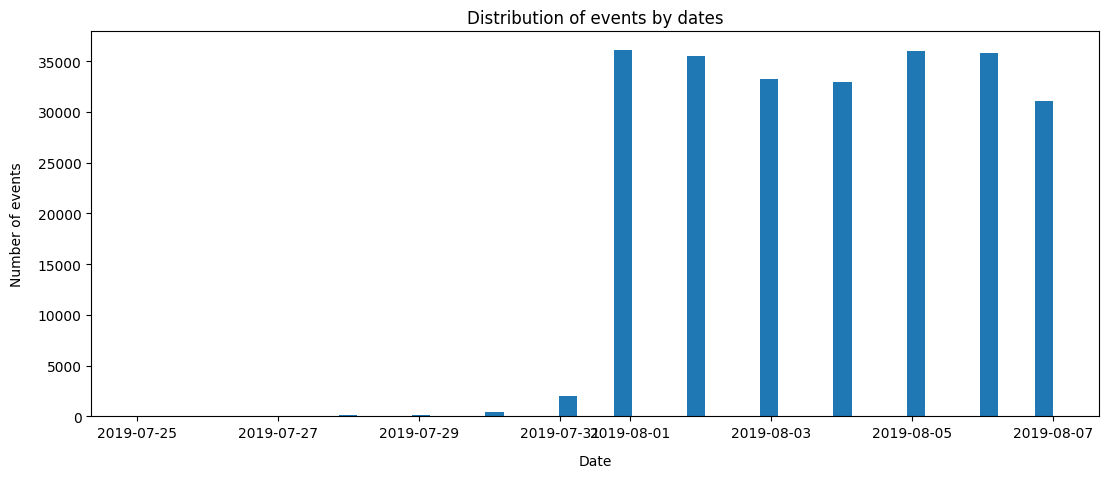

In [ ]:
plt.figure(figsize= (13, 5))
plt.hist(df_logs['event_date'], bins = 50)
plt.title('Distribution of events by dates')
plt.xlabel('Date', labelpad=10)
plt.ylabel('Number of events', labelpad=10)
plt.show()

**In fact, we only have complete data for the period from 2019-08-01 to 2019-08-07. We will only consider data for these 7 days and discard the rest of the events.**

In [ ]:
#Creating filtered tables based on dates from 2019-08-01 to 2019-08-07
df_logs_good = df_logs.query('event_date >= "2019-08-01" and event_date <= "2019-08-07"')

#Counting the number of lost events and users after filtering
print('As a result of data filtering, we lost {} ({:.2%}) events and {} ({:.2%}) users.'.format(
len(df_logs) - len(df_logs_good), (len(df_logs) - len(df_logs_good))/len(df_logs),  len(df_logs.user_id.unique()) - len(df_logs_good.user_id.unique()), (len(df_logs.user_id.unique()) - len(df_logs_good.user_id.unique()))/len(df_logs.user_id.unique())))

As a result of data filtering, we lost 2826 (1.16%) events and 17 (0.23%) users.


Check the number of users in each group.

In [ ]:
df_group_count = df_logs_good.groupby('group')['user_id'].nunique().reset_index()

#Adding the result for the combined control groups to the table
control_groups = pd.DataFrame(
    [['246+247', df_logs_good[(df_logs_good['group']==246) | (df_logs_good['group']==247)]['user_id'].nunique()]],
    columns = ['group', 'user_id'])
df_group_count = pd.concat([df_group_count, control_groups]).reset_index(drop=True)

df_group_count


,group,user_id
0,246,2484
1,247,2513
2,248,2537
3,246+247,4997


The distribution of users across the groups is fairly even.

## Funnel analysis

Calculate the frequency of each event.

In [ ]:
df_eventname_count = df_logs_good.groupby('event_name')['user_id'].count().reset_index().sort_values('user_id', ascending=False)
df_eventname_count.columns = ['event_name', 'count']
df_eventname_count

,event_name,count
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Calculate the number of users (and the proportion of users) who performed each of these events.

In [ ]:
#Grouping the table by event names and counting the number of unique users
df_eventname_userunique = df_logs_good.groupby('event_name')['user_id'].nunique().reset_index().sort_values('user_id', ascending=False)
df_eventname_userunique.columns = ['event_name', 'user_counts']
#Creating a column with the proportion of users in each event out of the total number of unique users in df_logs_good
df_eventname_userunique['part'] = (df_eventname_userunique['user_counts'] / len(df_logs_good.user_id.unique())).round(2)
df_eventname_userunique

,event_name,user_counts,part
1,MainScreenAppear,7419,0.98
2,OffersScreenAppear,4593,0.61
0,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


**Based on the proportions of users in each event, we can assume that the events occur in the following order:**
1. MainScreenAppear - main screen
2. OffersScreenAppear - offer screen
3. CartScreenAppear - cart screen
4. PaymentScreenSuccessful - successful payment screen

**This order appears to be correct based on the logic of app usage.
The "Tutorial" event, listed at the end of the funnel table, does not seem to be a logical continuation of the payment process. It is likely that this event does not affect the others, so we will not include it in the funnel analysis.**

**We also see that not all users enter the app through the main screen. Apparently, 2% of users directly access the offer screen through various advertising links.**

Calculate the conversion rate to each subsequent event, i.e., the proportion of users who proceed to the next step in the funnel (from the number of users in the previous event).

In [ ]:
#Removing the 'Tutorial' event from the df_eventname_userunique table for funnel visualization
df_eventname_convers = df_eventname_userunique.reset_index(drop=True).drop(index=[4])
df_eventname_convers

,event_name,user_counts,part
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47


In [ ]:
#Calculating the conversion to the next event.
#Iterating through the rows in the table. Starting from the second row, finding the ratio of user_counts to the previous row

part_from_prev = []
for i in df_eventname_convers.index:
    if i == 0:
        part = 1
    else:
        part = (df_eventname_convers.loc[i][1]/df_eventname_convers.loc[i-1][1]).round(2)
    part_from_prev.append(part)

df_eventname_convers['part_from_prev'] = part_from_prev
df_eventname_convers

,event_name,user_counts,part,part_from_prev
0,MainScreenAppear,7419,0.98,1.00
1,OffersScreenAppear,4593,0.61,0.62
2,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95


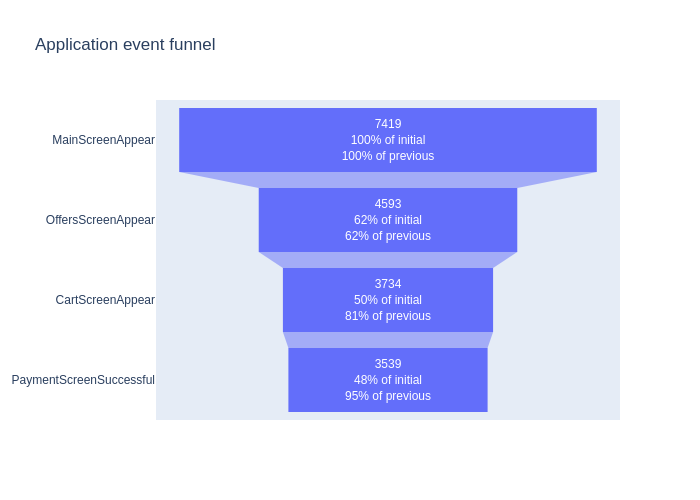

In [ ]:
#Creating a list of events
events = df_eventname_convers['event_name']

fig = go.Figure(
    go.Funnel(
        y=events,
        x=df_eventname_convers['user_counts'],
        textposition = "inside",
        textinfo = "value+percent previous+percent initial",

    )
)
fig.update_layout(height=500, width=700, title='Application event funnel')
fig.show("png")


**Based on the conversion rates obtained, we can determine that the majority of users drop off after the first event. Only 62% proceed to the offer screen. This may indicate that the interface of the main screen is not user-friendly for continuing app usage.**

In [ ]:
print('Conversion rate from the first event to payment: ', (
    df_eventname_convers.loc[3][1] / df_eventname_convers.loc[0][1]).round(2))

Conversion rate from the first event to payment:  0.48


**Less than half of the users (48%) reach the successful payment screen from the first event.**

Examine the product funnel considering the sequence of events.

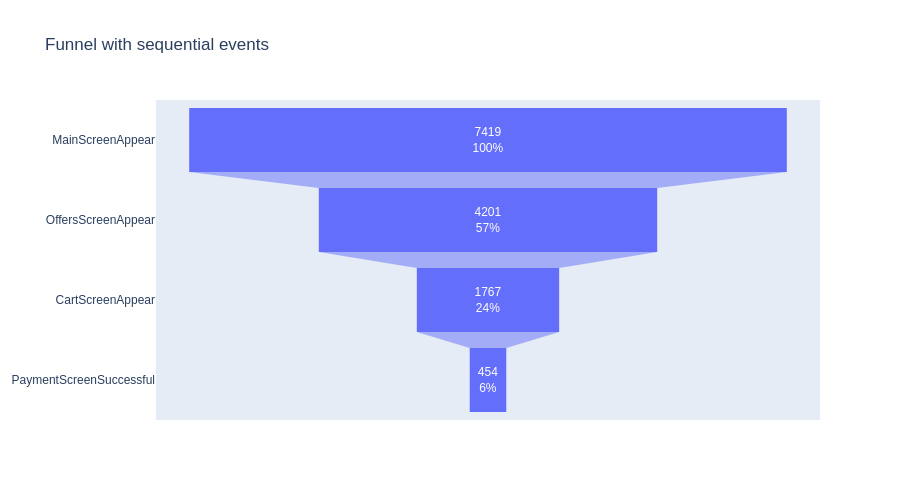

In [ ]:
#Finding the time of users' first actions for each event
users = df_logs_good[df_logs_good['event_name'] != 'Tutorial'].pivot_table(
        index='user_id',
        columns='event_name',
        values='event_timestamp',
        aggfunc='min').reset_index()

#Finding the count (number of rows) of users who started from the first event
#and had a subsequent event time greater than the previous one
funnel_seq = []
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])
funnel_seq.append(users[step_1].shape[0])
funnel_seq.append(users[step_2].shape[0])
funnel_seq.append(users[step_3].shape[0])
funnel_seq.append(users[step_4].shape[0])


fig = go.Figure(
    go.Funnel(
        y=events,
        x=funnel_seq,
        textposition = "inside",
        textinfo = "value+percent initial",
   )
)
fig.update_layout(height=500, width=900, title='Funnel with sequential events')
fig.show("png")

**Comparing the two funnels, we observe that not all users follow the expected path of events.**

##  A/A/B test results analysis

In [ ]:
#Calculating the proportion of users in each group out of the total count
df_group_count['part'] = (df_group_count['user_id'] / len(df_logs_good.user_id.unique())).round(2)
df_group_count.index = df_group_count['group']
df_group_count = df_group_count.drop(columns='group')

df_group_count

,user_id,part
group,,
246,2484,0.33
247,2513,0.33
248,2537,0.34
246+247,4997,0.66


**As previously noted, the distribution of users across the groups is fairly even (33-34%).**

Calculate the number of users for each event in each group separately.

In [ ]:
#Creating a list of groups
groups = df_group_count.index

#Creating a table with the funnel: counting the number of unique users for each event in each group
funnel = {}
for group in groups:
    funnel[group] = []
    for event in events:
        funnel[group].append(df_logs_good[(df_logs_good['group'] == group) & (df_logs_good['event_name'] == event)]['user_id'].nunique())


df_funnel = pd.DataFrame(funnel)
df_funnel['246+247'] = df_funnel[246] + df_funnel[247]
df_funnel['event_name'] = events
df_funnel

,246,247,248,246+247,event_name
0,2450,2476,2493,4926,MainScreenAppear
1,1542,1520,1531,3062,OffersScreenAppear
2,1266,1238,1230,2504,CartScreenAppear
3,1200,1158,1181,2358,PaymentScreenSuccessful


**Most popular event in all groups is 'MainScreenAppear'.**

Let's create a funnel analysis with conversions for each group pair and test the statistical significance of the conversion results.

In [ ]:
#Function to calculate p-value (for each event) and build the funnel for two groups
def p_value_test(group_1, group_2, alpha):
    alpha = alpha
    for i in df_funnel.index:
        #Proportion of users who moved to the event in the first group
        p1 = df_funnel[group_1][i] / df_group_count['user_id'][group_1]
        #Proportion of users who moved to the event in the second group
        p2 = df_funnel[group_2][i] / df_group_count['user_id'][group_2]
        #Proportion of users who moved to the event in both groups combined
        p12 = (df_funnel[group_1][i] + df_funnel[group_2][i]) / (df_group_count['user_id'][group_1] + df_group_count['user_id'][group_2])
        #Difference in proportions between the groups
        difference = p1 - p2
        # Calculating the statistics in standard deviations of the standard normal distribution
        z_value = difference / mth.sqrt(p12 * (1 - p12) *
                                        (1/df_group_count['user_id'][group_1] + 1/df_group_count['user_id'][group_2]))
        # Assuming a standard normal distribution (mean 0, standard deviation 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('{} p-value: {}'.format(df_funnel['event_name'][i], p_value))
        if (p_value < alpha):
            print("We reject the null hypothesis: there is a significant difference between the proportions.")
        else:
            print("We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.")
        print('')

    fig = go.Figure()
    for i, group in enumerate([group_1, group_2]):
        fig.add_trace(go.Funnel(
            name = str(group),
            y = events,
            x = df_funnel[group],
            textposition = "inside",
            textinfo = "value+percent previous+percent initial",))
    fig.update_layout(height=500, width=800, title='Application Event Funnel')
    fig.show("png")

Since we will be conducting 16 tests on the same data, we will use the Bonferroni correction to adjust the significance level.

Groups 246 and 247 (A/A test):

MainScreenAppear p-value: 0.7570597232046099
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

OffersScreenAppear p-value: 0.2480954578522181
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

CartScreenAppear p-value: 0.22883372237997213
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

PaymentScreenSuccessful p-value: 0.11456679313141849
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.



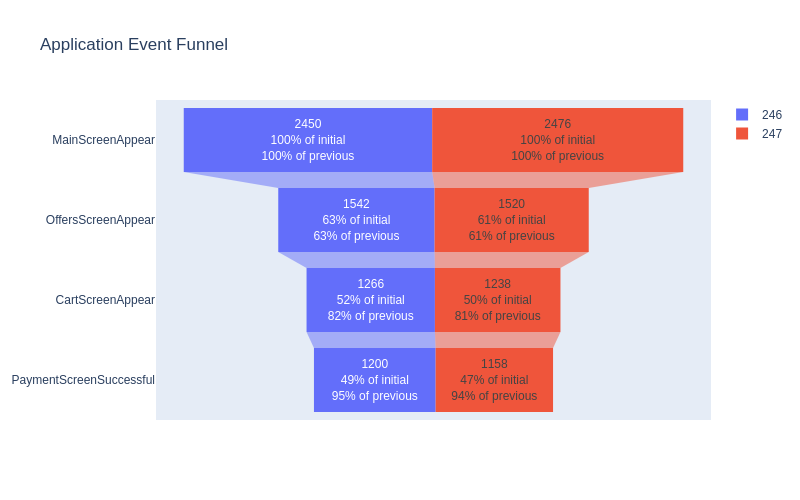

In [ ]:
p_value_test(246, 247, 0.05/16)

**From the results, we can see that none of the events showed significant differences. Both these groups can be considered as control groups, and we can trust the distribution of users in the test group.**

Similarly, let's compare the test group (248) with each of the control groups (246 and 247).

Groups 246 and 248:

MainScreenAppear p-value: 0.2949721933554552
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

OffersScreenAppear p-value: 0.20836205402738917
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

CartScreenAppear p-value: 0.07842923237520116
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

PaymentScreenSuccessful p-value: 0.2122553275697796
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.



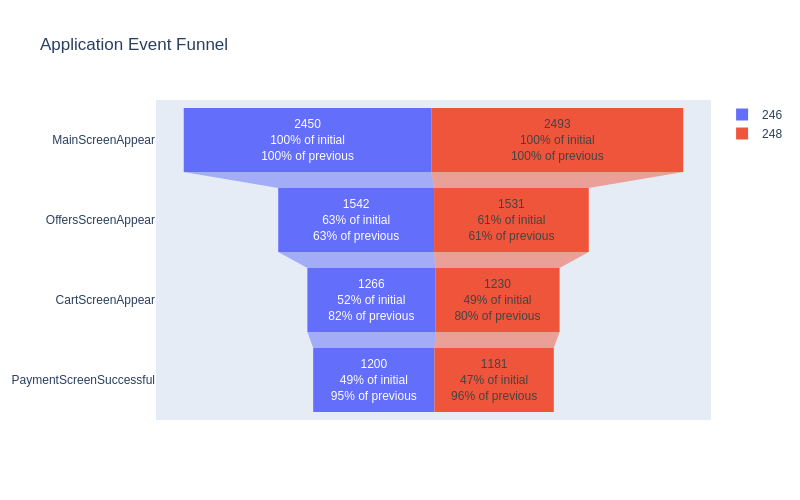

In [ ]:
p_value_test(246, 248, 0.05/16)

Groups 247 and 248:

MainScreenAppear p-value: 0.4587053616621515
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

OffersScreenAppear p-value: 0.9197817830592261
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

CartScreenAppear p-value: 0.5786197879539783
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

PaymentScreenSuccessful p-value: 0.7373415053803964
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.



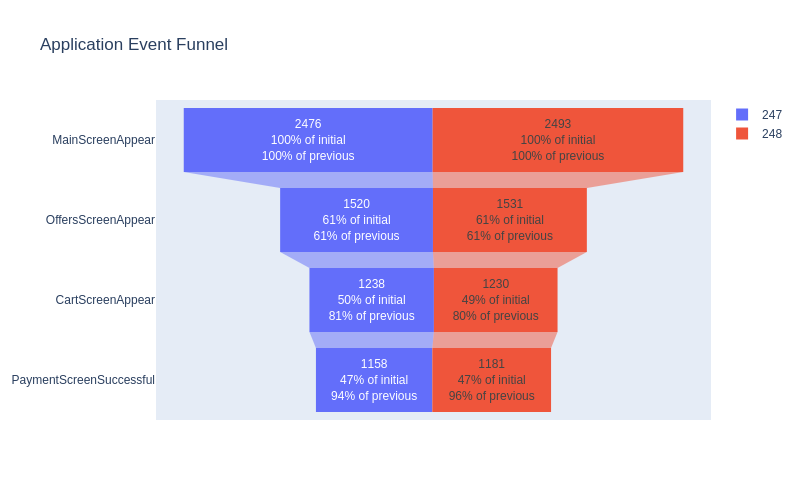

In [ ]:
p_value_test(247, 248, 0.05/16)

**When comparing the control groups with the test group, none of the events showed significant differences.**

Now, let's compare the combined control groups 246 and 247 with the test group 248:

MainScreenAppear p-value: 0.29424526837179577
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

OffersScreenAppear p-value: 0.43425549655188256
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

CartScreenAppear p-value: 0.18175875284404386
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.

PaymentScreenSuccessful p-value: 0.6004294282308704
We fail to reject the null hypothesis: there is no evidence to suggest that the proportions are different.



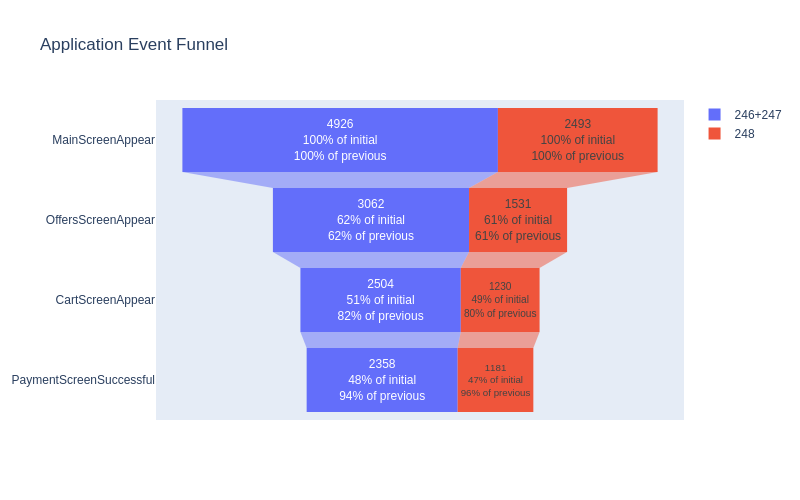

In [ ]:
p_value_test('246+247', 248, 0.05/16)

**Comparing the test group with the combined control groups also did not show statistically significant differences in conversions.**

## Conclusions:

After analyzing the logs of the mobile app, we can draw the following conclusions:

- the most popular event is 'MainScreenAppear';


- It is also the first event in the funnel:
    1. MainScreenAppear - Main screen
    2. OffersScreenAppear - Offer screen
    3. CartScreenAppear - Cart screen
    4. PaymentScreenSuccessful - Successful payment screen  


- 48% of users reach the payment (end of the funnel);


- the lowest conversion rate is observed from MainScreenAppear to OffersScreenAppear, indicating possible deficiencies in the main screen interface;


- we conducted 16 tests for statistical hypotheses with a significance level of 0.05 (using the Bonferroni correction for multiple tests), 12 of which tested the difference between the control groups and the group with the font change, and none of them revealed significant differences, indicating no difference in conversion rates for the compared fonts.

